In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
#load data and scale data
X_train=pd.read_csv('data/tfidf_train_X.csv')
X_test=pd.read_csv('data/tfidf_test_X.csv')
y_train=pd.read_csv('data/y_train.csv')
y_test=pd.read_csv('data/y_test.csv')

In [3]:
y_test.loc[(y_test['rating'] >= 5), 'rating_class'] = 1
y_test.loc[(y_test['rating'] < 5), 'rating_class'] = 0
y_train.loc[(y_train['rating'] >= 5), 'rating_class'] = 1
y_train.loc[(y_train['rating'] < 5), 'rating_class'] = 0
y_train_c=y_train.drop(columns=['rating'])
y_test_c=y_test.drop(columns=['rating'])

In [4]:
y_train_c.value_counts()

rating_class
1.0             28859
0.0             12332
dtype: int64

In [5]:
y_test_c.value_counts()

rating_class
1.0             12368
0.0              5286
dtype: int64

## Part V. develop review classification model
Previously, we tried to develop npl regression model for rating prediction. The results are not good based on the results using regularized linear regression and decision tree regression. We also tried support vector machine, random forest and gradient boosting. But we were not patient enough to get the data. It is very time-consuming. Thus, in this section, we decide to develop classification model by converting rating level into a binary variable, positive or negative. If rating >=5, positive. Otherwise, negative. 

Let's begin the journey and keep our finger crossed. 

### 5.1 classification model using tfidf transformed data

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
st_scaler=StandardScaler()
X_train_s=st_scaler.fit_transform(X_train)
X_test_s=st_scaler.transform(X_test)

After converting the problem into a classification one, I still worry about the running time for the algorithms. Maybe the pandas data frame as input data is not a good choice. The interesting thing is even when I convert it into scipy sparse matrix, it has the same size as pandas data frame. So I decided to keep the orginal data format.

In [7]:
#convert pandas dataframe into scipy sparse matrix, refer to https://towardsdatascience.com/working-with-sparse-data-sets-in-pandas-and-sklearn-d26c1cfbe067
from scipy.sparse import lil_matrix
import numpy as np
def data_frame_to_scipy_sparse_matrix(df):
    """
    Converts a sparse pandas data frame to sparse scipy csr_matrix.
    :param df: pandas data frame
    :return: csr_matrix
    """
    arr = lil_matrix(df.shape, dtype=np.float32)
    for i, col in enumerate(df.columns):
        ix = df[col] != 0
        arr[np.where(ix), i] = 1

    return arr.tocsr()
BYTES_TO_MB_DIV = 0.000001
def get_csr_memory_usage(matrix):
    mem = (matrix.data.nbytes + matrix.indptr.nbytes + matrix.indices.nbytes) * BYTES_TO_MB_DIV
    print("Memory usage is " + str(mem) + " MB")

In [8]:
X_train_s_df=pd.DataFrame(X_train_s, columns=X_train.columns, index=X_train.index)
X_test_s_df=pd.DataFrame(X_test_s, columns=X_test.columns, index=X_test.index)
X_csr_train_s = data_frame_to_scipy_sparse_matrix(X_train_s_df)
get_csr_memory_usage(X_csr_train_s)
X_csr_test_s = data_frame_to_scipy_sparse_matrix(X_test_s_df)
get_csr_memory_usage(X_csr_test_s)

Memory usage is 98.36411199999999 MB
Memory usage is 42.157756 MB


In [9]:
type(X_train_s)

numpy.ndarray

In [10]:
print("Memory usage of X_train_s is " + str(X_train_s.nbytes* BYTES_TO_MB_DIV) + " MB")
print("Memory usage of X_test_s is " + str(X_test_s.nbytes* BYTES_TO_MB_DIV) + " MB")

Memory usage of X_train_s is 98.199344 MB
Memory usage of X_test_s is 42.087136 MB


In [11]:
#optimize the hyperparameters in classification algorithms
def classification_tune(clf_estimator, param_grid, X_train, y_train, X_test, y_test):
    ##find the best model
    clf_random = RandomizedSearchCV(estimator = clf_estimator, param_distributions=param_grid, cv = 5, verbose=2, random_state=42, n_jobs = -1)
    clf_random.fit(X_train, y_train)
    best_clf=clf_random.best_estimator_
    y_pred=best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test_s)[::,1]
    print("BEST PARAMS", clf_random.best_params_)
    return best_clf, y_pred, y_pred_proba 
#evaluation of the classification models
def classification_eval(best_clf, y_test, y_pred, y_pred_proba):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g', ax=ax1)
    plt.tight_layout()
    ax1.set_title('Confusion matrix')
    ax1.set_ylabel('Actual label')
    ax1.set_xlabel('Predicted label')
    print("Accuracy:",accuracy_score(y_test, y_pred).round(3))
    print("Precision:",precision_score(y_test, y_pred).round(3))
    print("Recall:", recall_score(y_test, y_pred).round(3))
    print("f1 score:", f1_score(y_test, y_pred).round(3))
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba).round(3)
    ax2.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    return ax1, ax2 

#### 5.1.1 logistic regression

In [12]:
#let's start journey with the traditional regularized logistic regression model
param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]}
clf_estimator = LogisticRegression()
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train_c, X_test_s, y_test_c)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.5s finished


BEST PARAMS {'C': 50}


Accuracy: 0.809
Precision: 0.837
Recall: 0.903
f1 score: 0.869


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

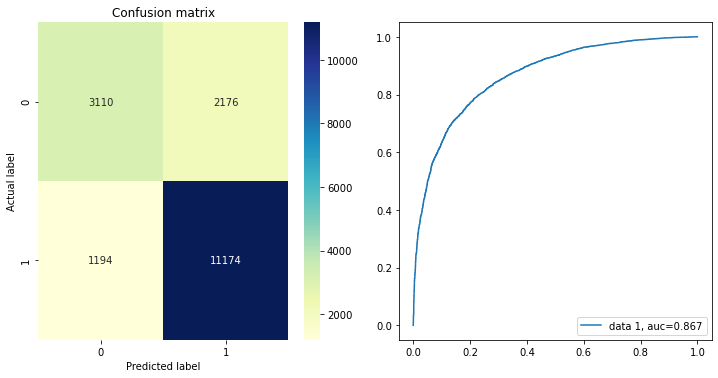

In [13]:
classification_eval(best_clf, y_test_c, y_pred, y_pred_proba)

Based on f1 score and auc value, the result is not bad. Because the data is imbalanced and the positive rating is the majority, we cannot solely use accuracy to evaluate the model. 

In [14]:
#use selectFromModel in sklearn to find the most important features in the best model
from sklearn.feature_selection import SelectFromModel
features_name=X_train.columns
sfm=SelectFromModel(best_clf, threshold=-np.inf, max_features=10)
sfm.fit(X_train_s, y_train_c)
feature_idx=sfm.get_support()
feature_name=features_name[feature_idx]
feature_name

Index(['usefulCount', 'year', 'vader_compound', 'textblob_polarity', 'con_1',
       'con_2', 'help', 'insert', 'love', 'remov'],
      dtype='object')

#### 5.1.2 decision tree

In [15]:
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth':[2,4,6,8,10,12]}
clf_estimator = DecisionTreeClassifier()
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train_c, X_test_s, y_test_c)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.0min finished


BEST PARAMS {'max_depth': 12, 'criterion': 'gini'}


Accuracy: 0.789
Precision: 0.82
Recall: 0.895
f1 score: 0.856


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

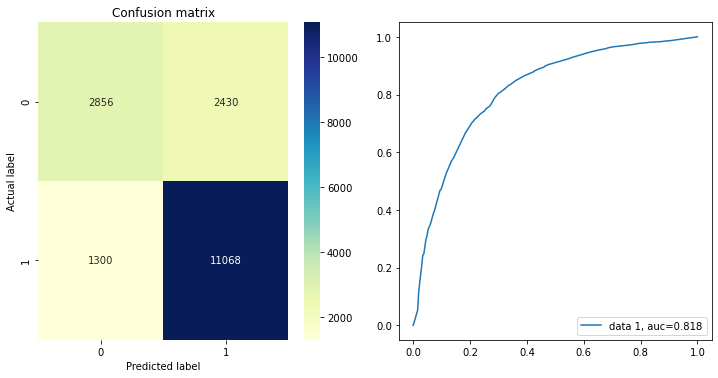

In [16]:
classification_eval(best_clf, y_test_c, y_pred, y_pred_proba)

Decision tree gave us comparable results to regularized logistic classification with slightly lower AUC and f1 score than logistic classification.

In [17]:
fea_importance=dict(zip(features_name, np.round(best_clf.feature_importances_, 2)))
sort_fea_importance={}
sorted_keys = sorted(fea_importance, key=fea_importance.get)
for i in sorted_keys[-10:]:
    sort_fea_importance[i]=fea_importance[i]
print(sort_fea_importance)

{'year.1': 0.01, 'cramp': 0.02, 'depress': 0.02, 'love': 0.02, 'remov': 0.02, 'insert': 0.03, 'year': 0.05, 'vader_compound': 0.07, 'usefulCount': 0.08, 'textblob_polarity': 0.25}


year, usefulcount, vader_compound, textblob_polarity are still the most important features just like in logistic regression model.

#### 5.1.3 xgb classification

In [18]:
gammas=[0.1, 0.2, 0.3, 0.4, 0.5]
subsamples=[0.5, 0.6, 0.7, 0.8]
n_estimators=[int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
max_depths=[int(x) for x in np.linspace(1, 10, num = 10)]
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
param_grid = {'gamma':gammas, 'subsample': subsamples, 'n_estimators': n_estimators, 'max_depth':max_depths, 'learning_rate': learning_rates}
clf_estimator=XGBClassifier(use_label_encoder=False)
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train_c, X_test_s, y_test_c)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 44.3min finished


[12:13:27] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
BEST PARAMS {'subsample': 0.6, 'n_estimators': 350, 'max_depth': 7, 'learning_rate': 0.5, 'gamma': 0.3}


Accuracy: 0.919
Precision: 0.934
Recall: 0.953
f1 score: 0.943


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

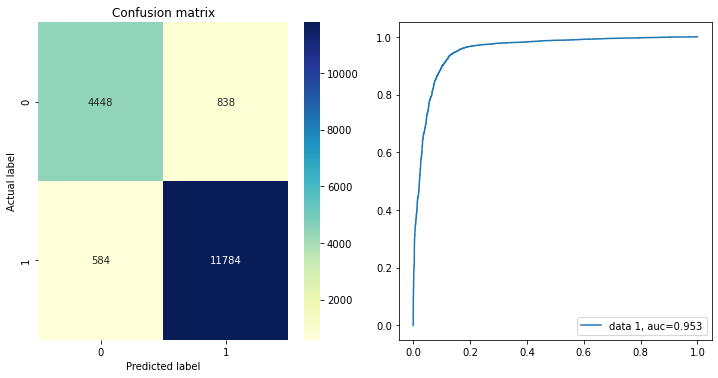

In [19]:
classification_eval(best_clf, y_test_c, y_pred, y_pred_proba)

In [20]:
fea_importance=dict(zip(features_name, np.round(best_clf.feature_importances_, 2)))
sort_fea_importance={}
sorted_keys = sorted(fea_importance, key=fea_importance.get)
for i in sorted_keys[-10:]:
    sort_fea_importance[i]=fea_importance[i]
print(sort_fea_importance)

{'scare': 0.01, 'slight': 0.01, 'straight': 0.01, 'thought': 0.01, 'wait': 0.01, 'week period': 0.01, 'wonder': 0.01, 'worri': 0.01, 'wors': 0.01, 'worst': 0.01}


#### 5.1.4 deep learning model

As a deep learning newbie, I decided to develop the simple RNN model for this project. Just wonder whether I am lucky enough to experience the magic of neural network. A deeper understanding of all parameters in ANN is necessary to develop the complicated system and optimize the relevant hyperparameters. 

In [21]:
# importing the libraries for deep learning model
# simple RNN, also called Vanilla RNN
#Create a sequential model including Dense layers
import keras 
from keras.models import Sequential
from keras.layers import Dense
# Model Structure
model = Sequential()
model.add(Dense(50, input_dim=298, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                14950     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 15,991
Trainable params: 15,991
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
206/206 [==============================] - 0s 2ms/step - loss: 0.4868 - accuracy: 0.7560
Epoch 2/30
206/206 [==============================] - 0s 2ms/step - loss: 0.3835 - accuracy: 0.8253
Epoch 3/30
206/206 [==============================] - 0s 2ms/step - loss: 0.3513 - accuracy: 0.8439
Epoch 4/30
206/206 [==============================] - 0s 1ms/step - loss: 0.3244 - accuracy: 0.8599
Epoch 5/30
206/206 [==============================] - 0s 2ms/step - loss: 0.2986 - accuracy: 0.8743
Epoch 6/30
206/206 [==============================] - 0s 2ms/step - loss: 0.2726 - accuracy: 0.8882
Epoch 7/30
206/206 [==============================] - 0s 2ms/step - loss: 0.2471 - accuracy: 0.9019
Epoch 8/30
206/206 [==============================] - 0s 1ms/step - loss: 0.2236 - accuracy: 0.9128
Epoch 9/30
206/206 [==============================] - 0s 1ms/step - loss: 0.2027 - accuracy: 0.9228
Epoch 10/30
206/206 [==============================] - 0s 1ms/step - loss: 0.1828 - accuracy: 0.9334

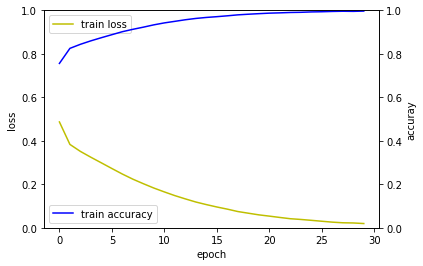

In [22]:
#plot model performance
#The batch size is a hyperparameter to controls the size of data each step.
#The number of epochs is a hyperparameter of gradient descent that controls how many weight updates should be done in the model.
history = model.fit(X_train_s, y_train_c, epochs=30, batch_size=200)
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])
loss_ax.plot(history.history['loss'], 'y', label='train loss')
acc_ax.plot(history.history['accuracy'], 'b', label='train accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()
#refer to https://github.com/sharmaroshan/Drugs-Recommendation-using-Reviews/blob/master/DrugsAnalysis.ipynb

In [23]:
y_pred = model.predict_classes(X_test_s)
print("Accuracy:",accuracy_score(y_test_c, y_pred).round(3))
print("Precision:",precision_score(y_test_c, y_pred).round(3))
print("Recall:", recall_score(y_test_c, y_pred).round(3))
print("f1 score:", f1_score(y_test_c, y_pred).round(3))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy: 0.907
Precision: 0.934
Recall: 0.933
f1 score: 0.934


The neural network model gave comparable results to xgb model.

### 5.2 classification model using tfidf LSA transformed data

#### 5.2.1  logistic regression

In [24]:
#load data and scale data
X_train=pd.read_csv('data/tfidf_lsa_train_X.csv')
X_test=pd.read_csv('data/tfidf_lsa_test_X.csv')
y_train=pd.read_csv('data/y_train.csv')
y_test=pd.read_csv('data/y_test.csv')
X_train_s=st_scaler.fit_transform(X_train)
X_test_s=st_scaler.transform(X_test)

In [25]:
#let's start with the traditional regularized logistic regression model
param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]}
clf_estimator = LogisticRegression()
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train_c, X_test_s, y_test_c)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.3s finished


BEST PARAMS {'C': 0.5}


Accuracy: 0.806
Precision: 0.832
Recall: 0.905
f1 score: 0.867


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

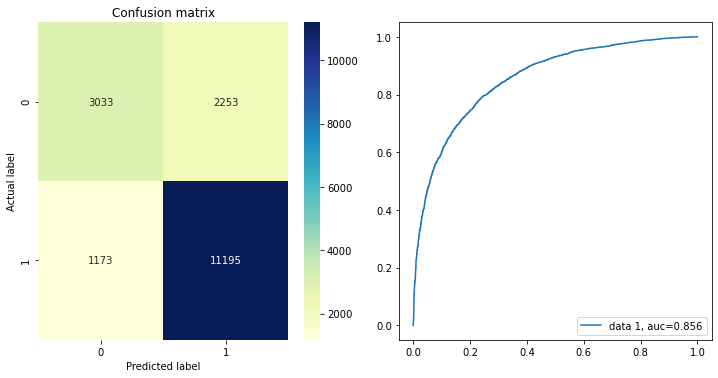

In [26]:
classification_eval(best_clf, y_test_c, y_pred, y_pred_proba)

In [27]:
#use selectFromModel in sklearn to find the most important features in the best model
from sklearn.feature_selection import SelectFromModel
features_name=X_train.columns
sfm=SelectFromModel(best_clf, threshold=-np.inf, max_features=10)
sfm.fit(X_train_s, y_train_c)
feature_idx=sfm.get_support()
feature_name=features_name[feature_idx]
feature_name

Index(['usefulCount', 'year', 'vader_compound', 'textblob_polarity', 'con_1',
       'con_2', 'component 2', 'component 4', 'component 8', 'component 10'],
      dtype='object')

#### 5.2.2 decision tree

In [28]:
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth':[2,4,6,8,10,12]}
clf_estimator = DecisionTreeClassifier()
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train_c, X_test_s, y_test_c)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


BEST PARAMS {'max_depth': 12, 'criterion': 'gini'}


Accuracy: 0.81
Precision: 0.842
Recall: 0.897
f1 score: 0.869


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

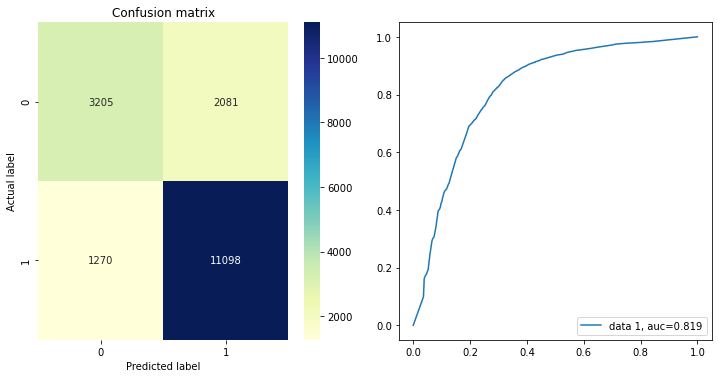

In [29]:
classification_eval(best_clf, y_test_c, y_pred, y_pred_proba)

tfidf LSA produced features and tfidf directly produced features get us similar performance when we use logistic and decision tree models.

In [30]:
fea_importance=dict(zip(features_name, np.round(best_clf.feature_importances_, 2)))
sort_fea_importance={}
sorted_keys = sorted(fea_importance, key=fea_importance.get)
for i in sorted_keys[-10:]:
    sort_fea_importance[i]=fea_importance[i]
print(sort_fea_importance)

{'component 97': 0.01, 'component 99': 0.01, 'component 4': 0.02, 'component 2': 0.03, 'component 8': 0.03, 'component 10': 0.03, 'year': 0.04, 'usefulCount': 0.06, 'vader_compound': 0.06, 'textblob_polarity': 0.18}


#### 5.2.3 xgb classification

In [31]:
gammas=[0.1, 0.2, 0.3, 0.4, 0.5]
subsamples=[0.5, 0.6, 0.7, 0.8]
n_estimators=[int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
max_depths=[int(x) for x in np.linspace(1, 10, num = 10)]
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
param_grid = {'gamma':gammas, 'subsample': subsamples, 'n_estimators': n_estimators, 'max_depth':max_depths, 'learning_rate': learning_rates}
clf_estimator=XGBClassifier(use_label_encoder=False)
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train_c, X_test_s, y_test_c)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 41.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 81.6min finished


[13:39:32] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
BEST PARAMS {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.3}


Accuracy: 0.926
Precision: 0.933
Recall: 0.964
f1 score: 0.948


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

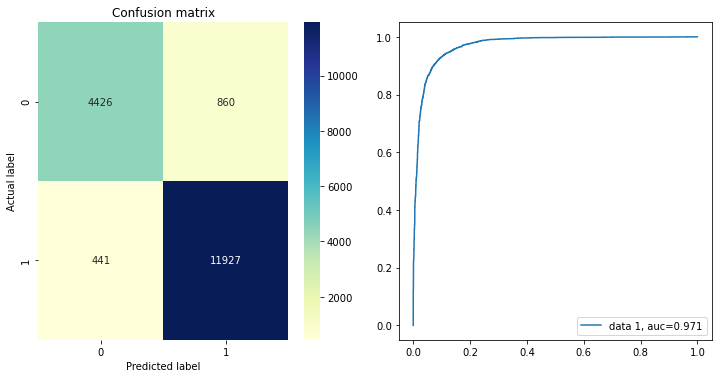

In [32]:
classification_eval(best_clf, y_test_c, y_pred, y_pred_proba)

In [33]:
fea_importance=dict(zip(features_name, np.round(best_clf.feature_importances_, 2)))
sort_fea_importance={}
sorted_keys = sorted(fea_importance, key=fea_importance.get)
for i in sorted_keys[-10:]:
    sort_fea_importance[i]=fea_importance[i]
print(sort_fea_importance)

{'component 98': 0.01, 'component 99': 0.01, 'vader_compound': 0.02, 'con_2': 0.02, 'component 4': 0.02, 'component 8': 0.02, 'component 10': 0.02, 'usefulCount': 0.03, 'year': 0.03, 'textblob_polarity': 0.06}


#### 5.2.4 deep learning model (artificial neural network (ANN) with the recurrent neural network (RNN) architecture)

In [39]:
import keras 
from keras.models import Sequential
from keras.layers import Dense
# Model Structure
model = Sequential()
model.add(Dense(50, input_dim=110, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 50)                5550      
_________________________________________________________________
dense_10 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 6,591
Trainable params: 6,591
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
206/206 [==============================] - 0s 2ms/step - loss: 0.4990 - accuracy: 0.7533
Epoch 2/30
206/206 [==============================] - 0s 2ms/step - loss: 0.4183 - accuracy: 0.8041
Epoch 3/30
206/206 [==============================] - 0s 2ms/step - loss: 0.3985 - accuracy: 0.8149
Epoch 4/30
206/206 [==============================] - 0s 2ms/step - loss: 0.3839 - accuracy: 0.8235
Epoch 5/30
206/206 [==============================] - 0s 2ms/step - loss: 0.3714 - accuracy: 0.8307
Epoch 6/30
206/206 [==============================] - ETA: 0s - loss: 0.3605 - accuracy: 0.83 - 0s 1ms/step - loss: 0.3601 - accuracy: 0.8373
Epoch 7/30
206/206 [==============================] - 0s 1ms/step - loss: 0.3491 - accuracy: 0.8451
Epoch 8/30
206/206 [==============================] - 0s 1ms/step - loss: 0.3392 - accuracy: 0.8508
Epoch 9/30
206/206 [==============================] - 0s 1ms/step - loss: 0.3291 - accuracy: 0.8557
Epoch 10/30
206/206 [==============================] - 0s 

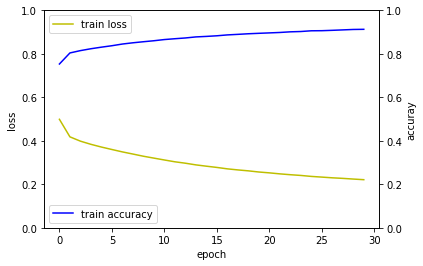

In [40]:
history = model.fit(X_train_s, y_train_c, epochs=30, batch_size=200)
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])
loss_ax.plot(history.history['loss'], 'y', label='train loss')
acc_ax.plot(history.history['accuracy'], 'b', label='train accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

In [41]:
y_pred = model.predict_classes(X_test_s)
print("Accuracy:",accuracy_score(y_test_c, y_pred).round(3))
print("Precision:",precision_score(y_test_c, y_pred).round(3))
print("Recall:", recall_score(y_test_c, y_pred).round(3))
print("f1 score:", f1_score(y_test_c, y_pred).round(3))

Accuracy: 0.84
Precision: 0.865
Recall: 0.914
f1 score: 0.889


Well, this deep learning model didn't give us much better results compared with xgb. xgb is the best performer using tfidf lsa produced features.

Good references for deep learning beginners:
https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/
https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/